In [1]:
##import the required libraries and APIs
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping




import matplotlib.pyplot as plt


import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

print(tf.__version__)

2.16.1


In [2]:
#importing the preprocessed data 
df= pd.read_csv('../data/processed/preprocessed_dataset.csv')


In [3]:
df.head()

,title,year,image_link,imdb_id,rating_count,rating,genre,keywords,trailer_link,actors,director,synopsis,processed_plot
0,Gladiator,2000,https://m.media-amazon.com/images/M/MV5BMDliMm...,tt0172495,1617220,8.5,"[Action, Adventure, Drama]","[roman empire, gladiator, slavery, combat, bat...",https://www.imdb.com/video/vi2628367897/,"[Russell Crowe, Joaquin Phoenix, Connie Nielsen]",[Ridley Scott],"Shouting ""Roma Invicta!"" as his forces attack,...",shouting rom invicta force attack general maxi...
1,Unbreakable,2000,https://m.media-amazon.com/images/M/MV5BMDIwMj...,tt0217869,440860,7.3,"[Drama, Mystery, Sci-Fi]","[supernatural power, train crash, superhero, c...",https://www.imdb.com/video/vi1103346201/,"[Bruce Willis, Samuel L. Jackson, Robin Wright]",[M. Night Shyamalan],The film opens as we see a baby being born in ...,film open see baby born west philadelphia elij...
2,Snatch,2000,https://m.media-amazon.com/images/M/MV5BMTA2ND...,tt0208092,909299,8.2,"[Comedy, Crime]","[diamond, boxer, narrated by character, cockne...",https://www.imdb.com/video/vi1558577433/,"[Jason Statham, Brad Pitt, Stephen Graham]",[Guy Ritchie],After stealing an 86-carat (17 g) diamond in a...,stealing carat g diamond heist antwerp franki...
3,AmericanPsycho,2000,https://m.media-amazon.com/images/M/MV5BZTM2ZG...,tt0144084,713635,7.6,"[Crime, Drama, Horror]","[narcissism, materialism, serial murder, socio...",https://www.imdb.com/video/vi4060743449/,"[Christian Bale, Justin Theroux, Josh Lucas]",[Mary Harron],A white background. Red drops begin to fall pa...,white background red drop begin fall past open...
4,RequiemforaDream,2000,https://m.media-amazon.com/images/M/MV5BOTdiNz...,tt0180093,897414,8.3,[Drama],"[drug addiction, sex show, sex scene, prostitu...",https://www.imdb.com/video/vi2156069145/,"[Ellen Burstyn, Jared Leto, Jennifer Connelly]",[Darren Aronofsky],Harry Goldfarb (Jared Leto) and Tyrone Love (M...,harry goldfarb jared leto tyrone love marlon w...


In [5]:
df['merge_title']= df['processed_plot']+ df['title']
#***need to preprocess again my combining other columns for accurate result 

In [6]:
df.head()

,title,year,image_link,imdb_id,rating_count,rating,genre,keywords,trailer_link,actors,director,synopsis,processed_plot,merge_title
0,Gladiator,2000,https://m.media-amazon.com/images/M/MV5BMDliMm...,tt0172495,1617220,8.5,"[Action, Adventure, Drama]","[roman empire, gladiator, slavery, combat, bat...",https://www.imdb.com/video/vi2628367897/,"[Russell Crowe, Joaquin Phoenix, Connie Nielsen]",[Ridley Scott],"Shouting ""Roma Invicta!"" as his forces attack,...",shouting rom invicta force attack general maxi...,shouting rom invicta force attack general maxi...
1,Unbreakable,2000,https://m.media-amazon.com/images/M/MV5BMDIwMj...,tt0217869,440860,7.3,"[Drama, Mystery, Sci-Fi]","[supernatural power, train crash, superhero, c...",https://www.imdb.com/video/vi1103346201/,"[Bruce Willis, Samuel L. Jackson, Robin Wright]",[M. Night Shyamalan],The film opens as we see a baby being born in ...,film open see baby born west philadelphia elij...,film open see baby born west philadelphia elij...
2,Snatch,2000,https://m.media-amazon.com/images/M/MV5BMTA2ND...,tt0208092,909299,8.2,"[Comedy, Crime]","[diamond, boxer, narrated by character, cockne...",https://www.imdb.com/video/vi1558577433/,"[Jason Statham, Brad Pitt, Stephen Graham]",[Guy Ritchie],After stealing an 86-carat (17 g) diamond in a...,stealing carat g diamond heist antwerp franki...,stealing carat g diamond heist antwerp franki...
3,AmericanPsycho,2000,https://m.media-amazon.com/images/M/MV5BZTM2ZG...,tt0144084,713635,7.6,"[Crime, Drama, Horror]","[narcissism, materialism, serial murder, socio...",https://www.imdb.com/video/vi4060743449/,"[Christian Bale, Justin Theroux, Josh Lucas]",[Mary Harron],A white background. Red drops begin to fall pa...,white background red drop begin fall past open...,white background red drop begin fall past open...
4,RequiemforaDream,2000,https://m.media-amazon.com/images/M/MV5BOTdiNz...,tt0180093,897414,8.3,[Drama],"[drug addiction, sex show, sex scene, prostitu...",https://www.imdb.com/video/vi2156069145/,"[Ellen Burstyn, Jared Leto, Jennifer Connelly]",[Darren Aronofsky],Harry Goldfarb (Jared Leto) and Tyrone Love (M...,harry goldfarb jared leto tyrone love marlon w...,harry goldfarb jared leto tyrone love marlon w...


In [7]:
df.columns

Index(['title', 'year', 'image_link', 'imdb_id', 'rating_count', 'rating',
       'genre', 'keywords', 'trailer_link', 'actors', 'director', 'synopsis',
       'processed_plot', 'merge_title'],
      dtype='object')

In [8]:
#create corpus from preprocessed plot
corpus=df['processed_plot']
print(corpus[5])

leonard shelby guy pearce man whose short term memory damaged struck head confronting two people attacking wife leonard kill one attacker one last thing leonard remembers wife dying leonard devotes life finding killing second attacker movie color black white sequence black white sequence proceed chronological order color sequence reverse chronological orderleonard wake room discount inn puzzled unknown caller call leonard say suffers anterograde amnesia condition make unable create new memory describes condition detailing story sammy jankis stephen tobolowsky leonard system note bring speed every time memory reset leonard tattoo john g raped murdered wife well clue tattooed bodyleonard insurance investigator investigated sammy sammys claim denied company classified symptom mental mr jankins tried convince leonard didnt change opinion went coma never recovered sammy went mental hospital unknown caller talk police never believed leonard story second attacker caller say cop provides addit

# Set up tokenizer 

In [11]:
# Tokenization and Padding
max_words = 10000# Choose the maximum number of words to be used in the vocabulary
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>") #oov replaces any unknown words with token of our choice
tokenizer.fit_on_texts(df['processed_plot'])

vocab_size = len(tokenizer.word_index) + 1
sequences = tokenizer.texts_to_sequences(df['processed_plot']) #converts text to numbers 
padded_sequences = pad_sequences(sequences,padding='post',truncating='post',maxlen=200) #adjust sequences to the same length


In [12]:
print(tokenizer.word_index)

{'<OOV>': 1, 'tell': 2, 'go': 3, 'get': 4, 'one': 5, 'find': 6, 'back': 7, 'take': 8, 'say': 9, 'see': 10, 'time': 11, 'two': 12, 'make': 13, 'life': 14, 'home': 15, 'asks': 16, 'come': 17, 'day': 18, 'man': 19, 'house': 20, 'try': 21, 'new': 22, 'father': 23, 'family': 24, 'friend': 25, 'want': 26, 'car': 27, 'also': 28, 'mother': 29, 'later': 30, 'meet': 31, 'call': 32, 'give': 33, 'away': 34, 'help': 35, 'room': 36, 'year': 37, 'next': 38, 'show': 39, 'kill': 40, 'run': 41, 'return': 42, 'woman': 43, 'start': 44, 'night': 45, 'know': 46, 'begin': 47, 'first': 48, 'work': 49, 'like': 50, 'he': 51, 'way': 52, 'another': 53, 'look': 54, 'film': 55, 'doesnt': 56, 'end': 57, 'love': 58, 'girl': 59, 'head': 60, 'people': 61, 'would': 62, 'leaf': 63, 'john': 64, 'police': 65, 'going': 66, 'still': 67, 'school': 68, 'leave': 69, 'men': 70, 'turn': 71, 'however': 72, 'son': 73, 'story': 74, 'wife': 75, 'young': 76, 'child': 77, 'around': 78, 'escape': 79, 'death': 80, 'money': 81, 'team': 82

In [13]:
print(vocab_size)

94497


In [14]:
padded_sequences[:2]

array([[4639,    1,    1,  173,  119,  769, 5396,    1,    1, 1169, 9470,
         187, 1801,  430, 2128,    1,    1,   37, 3575, 1592,    1,  206,
        4815,    1, 1556, 4816,  629,    1,  432,  803,    1,   73, 9763,
        7159, 3576,  121,    1, 5703, 4640,    1, 5396, 1981,  154,   42,
         223, 1801, 5796,    1,  565, 5396,  155,   11, 2876, 3951, 9763,
        7768, 6437,  322,    1, 4816, 9763,   16, 5396, 4575, 5396,  735,
        9763, 2595, 4816,   80,  158, 9763,   88, 5396, 3257, 4758,    1,
         338,  322, 5396,   75,   73, 5396, 3226,   79, 3257,  517,   15,
         545,   24,    1,    1,  117,    1, 2059,    1, 6774,   75,   73,
        5704, 5396, 6340, 7769, 1262,    1, 6889,    6, 5396,    8,    1,
           1,    1, 1326, 2696, 5397,    1,   60,  228,    1,   68, 1734,
           1,   80,   24, 4129, 2673, 5396,  957,  158,   85, 3148, 2956,
           1, 2295, 1489,  187, 1145, 4576,  702,  273,   85, 5396, 2296,
           1,    1,    1,    1,    1, 

# Define the LSTM model

In [15]:
# Build the LSTM model
maxlen = 200
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=64, input_length=maxlen),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5)
])

model.compile(loss='mse', optimizer='adam')
early_stopping = EarlyStopping(monitor='loss', patience=10, verbose=1) #to prevent overfitting

model.fit(padded_sequences, padded_sequences, epochs=20, validation_split=0.2,verbose=1,shuffle=True,callbacks=[early_stopping])
lstm_embeddings =model.predict(padded_sequences)


Epoch 1/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 3417415.7500 - val_loss: 2572872.2500
Epoch 2/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 3393834.7500 - val_loss: 2572872.2500
Epoch 3/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 3423402.5000 - val_loss: 2572872.2500
Epoch 4/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 3478109.2500 - val_loss: 2572872.2500
Epoch 5/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 3375054.7500 - val_loss: 2572872.2500
Epoch 6/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 3453756.7500 - val_loss: 2572872.2500
Epoch 7/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 3415726.5000 - val_loss: 2572872.2500
Epoch 8/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 3445104.2500 - val_loss: 2572872.2500
Epoch 9/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 3348238.0000 - val_loss: 2572872.2500
Epoch 10/20
189/189 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step - loss: 3389231.2500 - val_loss: 2572872.2500

In [16]:
lstm_embeddings

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 64)        │     6,047,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,255,173 (69.64 MB)

 Trainable params: 6,085,057 (23.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 12,170,116 (46.43 MB)

In [18]:
# Apply K-Means Clustering on LSTM Embeddings
num_clusters = 10  # Set the desired number of clusters
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(lstm_embeddings)

fit_predict is used instead of fit . fit trains the model based only on the input data while fit_predict trains the data also assign each data points to a cluster based on the learned centroid. 

In [19]:
# Add cluster labels to the original dataset
df['cluster_label'] = cluster_labels  #gives the cluster assignment of all our data points and stores in df  

In [20]:
# Display the clustered data
df['cluster_label'].value_counts()

cluster_label
0    7546
1       7
Name: count, dtype: int64

In [21]:
kmeans.cluster_centers_ # gives the learned cluster centroids

array([[1.        ],
       [0.99999994],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ],
       [1.        ]], dtype=float32)

# Visualise the metrics 

In [22]:
# Find the optimal number of clusters using silhouette score
silhouette_scores = []
for num_clusters in tqdm(range(2, 20)):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(lstm_embeddings)
    silhouette_scores.append(silhouette_score(lstm_embeddings, cluster_labels))

optimal_num_clusters = silhouette_scores.index(max(silhouette_scores)) + 2
optimal_num_clusters

100%|██████████| 18/18 [00:09<00:00,  1.86it/s]


2

In [23]:
silhouette_avg = silhouette_score(lstm_embeddings, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 1.0


In [24]:
wcss_80 = []
for i in tqdm(range(1, 30,2)):
    clustering = KMeans(n_clusters=i, init='k-means++', random_state=42)
    clustering.fit_predict(lstm_embeddings)
    wcss_80.append(clustering.inertia_)

100%|██████████| 15/15 [00:00<00:00, 17.25it/s]


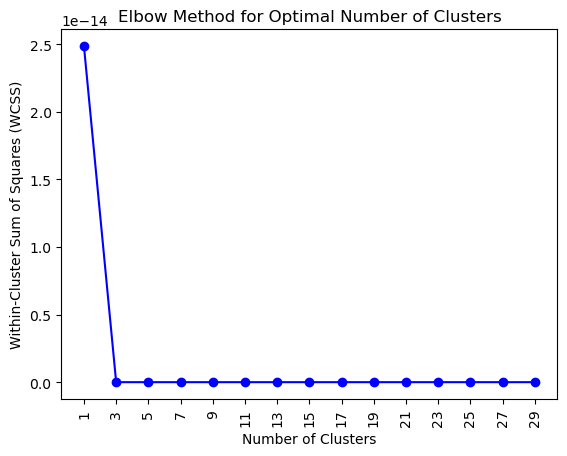

In [25]:
plt.plot(range(1, 30, 2), wcss_80, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.xticks(range(1, 30, 2))
plt.xticks(rotation=90)
plt.show()

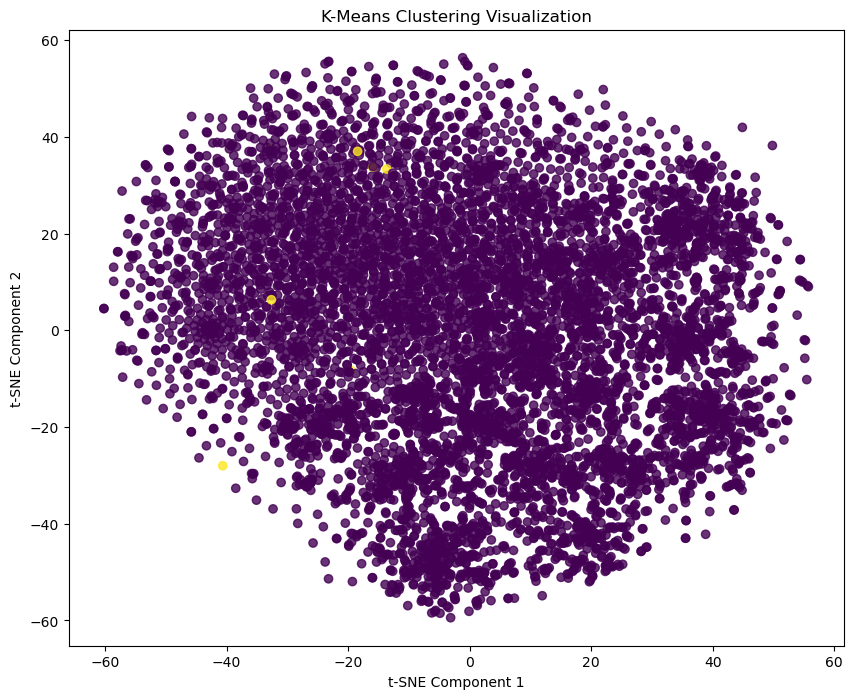

In [26]:
# Visualize the clustering using t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(padded_sequences) # padded sequence data is fetched to the model 

# Plot the clusters
plt.figure(figsize=(10, 8))
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis', alpha=0.8)
plt.title("K-Means Clustering Visualization")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()


In [27]:
tsne_embeddings

array([[-38.217293,  29.462301],
       [-27.276081,   4.18689 ],
       [-48.875507,  10.543248],
       ...,
       [ 12.391756,  14.627578],
       [ 22.949028,  15.356554],
       [  5.52071 ,  11.276906]], dtype=float32)

# Hyperparameter Tuning 

In [28]:
#trying different values for number of clusters
for n_clusters in range(2,20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(lstm_embeddings)
    silhouette_avg = silhouette_score(lstm_embeddings, cluster_labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

Silhouette Score for 2 clusters: 1.0
Silhouette Score for 3 clusters: 1.0
Silhouette Score for 4 clusters: 1.0
Silhouette Score for 5 clusters: 1.0
Silhouette Score for 6 clusters: 1.0
Silhouette Score for 7 clusters: 1.0
Silhouette Score for 8 clusters: 1.0
Silhouette Score for 9 clusters: 1.0
Silhouette Score for 10 clusters: 1.0
Silhouette Score for 11 clusters: 1.0
Silhouette Score for 12 clusters: 1.0
Silhouette Score for 13 clusters: 1.0
Silhouette Score for 14 clusters: 1.0
Silhouette Score for 15 clusters: 1.0
Silhouette Score for 16 clusters: 1.0
Silhouette Score for 17 clusters: 1.0
Silhouette Score for 18 clusters: 1.0
Silhouette Score for 19 clusters: 1.0


# Randomised Search CV

In [29]:
from sklearn.model_selection import RandomizedSearchCV

# Example: Random search for hyperparameter tuning
param_dist = {
    'n_clusters': [2,4,6,8,10,16,18],
    'init': ['k-means++', 'random'],
    'max_iter': [100, 200, 300, 400, 500]
}

random_search = RandomizedSearchCV(KMeans(), param_distributions=param_dist, n_iter=15, cv=15, random_state=42)
random_search_cluster= random_search.fit(lstm_embeddings)
print("Best Hyperparameters:", random_search.best_params_)

Best Hyperparameters: {'n_clusters': 4, 'max_iter': 400, 'init': 'k-means++'}


In [30]:
randomizedsearch_labels= random_search_cluster.best_estimator_.labels_

In [31]:
#trying different values for number of clusters
for n_clusters in range(2,20):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(lstm_embeddings)
    silhouette_avg = silhouette_score(lstm_embeddings,randomizedsearch_labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

Silhouette Score for 2 clusters: 1.0
Silhouette Score for 3 clusters: 1.0
Silhouette Score for 4 clusters: 1.0
Silhouette Score for 5 clusters: 1.0
Silhouette Score for 6 clusters: 1.0
Silhouette Score for 7 clusters: 1.0
Silhouette Score for 8 clusters: 1.0
Silhouette Score for 9 clusters: 1.0
Silhouette Score for 10 clusters: 1.0
Silhouette Score for 11 clusters: 1.0
Silhouette Score for 12 clusters: 1.0
Silhouette Score for 13 clusters: 1.0
Silhouette Score for 14 clusters: 1.0
Silhouette Score for 15 clusters: 1.0
Silhouette Score for 16 clusters: 1.0
Silhouette Score for 17 clusters: 1.0
Silhouette Score for 18 clusters: 1.0
Silhouette Score for 19 clusters: 1.0


In [32]:
kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(lstm_embeddings)

In [33]:
df['cluster_label'] = cluster_labels
df['cluster_label'].value_counts()

cluster_label
0    7546
1       7
Name: count, dtype: int64

In [34]:
cluster_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

# Get movies based on similarity

In [36]:
import random
# Get user input for a movie plot
user_input_plot = input("Enter a movie plot: ")

# Tokenize and pad the user input
user_input_sequence = tokenizer.texts_to_sequences([user_input_plot])
user_input_padded = pad_sequences(user_input_sequence,padding='post', truncating='post')


# Get the embedding for the user input from LSTM 
user_input_embedding = model.predict(user_input_padded)


# Find movies in the same cluster as the user input
user_cluster_label = kmeans.predict(user_input_embedding)
similar_movies_indices = np.where(cluster_labels == user_cluster_label)[0]
random_indices= random.choices(similar_movies_indices,k=10)
similar_movies = df.iloc[random_indices]['title'].tolist()



print(f"\nSimilar Movies based on the entered plot:\n")
for idx, movie in enumerate(similar_movies, start=1):
    print(f"{idx}. {movie}\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Similar Movies based on the entered plot:

1. Okja

2. TheGreatBuster

3. StrawberryMansion

4. Atari:GameOver

5. ReservationRoad

6. AllQuietontheWesternFront

7. MeandOrsonWelles

8. Twisted:TheUntoldStoryofaRoyalVizier

9. APrivateWar

10. GhostWorld



In [37]:
user_cluster_label #which cluster input belongs to 

array([0], dtype=int32)

In [38]:
len(similar_movies)

10

In [39]:
similar_movies_indices

array([   0,    1,    2, ..., 7550, 7551, 7552])

In [40]:
df.head()

,title,year,image_link,imdb_id,rating_count,rating,genre,keywords,trailer_link,actors,director,synopsis,processed_plot,merge_title,cluster_label
0,Gladiator,2000,https://m.media-amazon.com/images/M/MV5BMDliMm...,tt0172495,1617220,8.5,"[Action, Adventure, Drama]","[roman empire, gladiator, slavery, combat, bat...",https://www.imdb.com/video/vi2628367897/,"[Russell Crowe, Joaquin Phoenix, Connie Nielsen]",[Ridley Scott],"Shouting ""Roma Invicta!"" as his forces attack,...",shouting rom invicta force attack general maxi...,shouting rom invicta force attack general maxi...,0
1,Unbreakable,2000,https://m.media-amazon.com/images/M/MV5BMDIwMj...,tt0217869,440860,7.3,"[Drama, Mystery, Sci-Fi]","[supernatural power, train crash, superhero, c...",https://www.imdb.com/video/vi1103346201/,"[Bruce Willis, Samuel L. Jackson, Robin Wright]",[M. Night Shyamalan],The film opens as we see a baby being born in ...,film open see baby born west philadelphia elij...,film open see baby born west philadelphia elij...,0
2,Snatch,2000,https://m.media-amazon.com/images/M/MV5BMTA2ND...,tt0208092,909299,8.2,"[Comedy, Crime]","[diamond, boxer, narrated by character, cockne...",https://www.imdb.com/video/vi1558577433/,"[Jason Statham, Brad Pitt, Stephen Graham]",[Guy Ritchie],After stealing an 86-carat (17 g) diamond in a...,stealing carat g diamond heist antwerp franki...,stealing carat g diamond heist antwerp franki...,0
3,AmericanPsycho,2000,https://m.media-amazon.com/images/M/MV5BZTM2ZG...,tt0144084,713635,7.6,"[Crime, Drama, Horror]","[narcissism, materialism, serial murder, socio...",https://www.imdb.com/video/vi4060743449/,"[Christian Bale, Justin Theroux, Josh Lucas]",[Mary Harron],A white background. Red drops begin to fall pa...,white background red drop begin fall past open...,white background red drop begin fall past open...,0
4,RequiemforaDream,2000,https://m.media-amazon.com/images/M/MV5BOTdiNz...,tt0180093,897414,8.3,[Drama],"[drug addiction, sex show, sex scene, prostitu...",https://www.imdb.com/video/vi2156069145/,"[Ellen Burstyn, Jared Leto, Jennifer Connelly]",[Darren Aronofsky],Harry Goldfarb (Jared Leto) and Tyrone Love (M...,harry goldfarb jared leto tyrone love marlon w...,harry goldfarb jared leto tyrone love marlon w...,0
